In [1]:
import PythonicDISORT
from PythonicDISORT.subroutines import _compare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import pi

Previously saved reference solutions will be loaded if F2PY-wrapped Stamnes' DISORT is unavailable.

In [2]:
disort_is_installed = True
try:
    import disort
except ImportError:
    disort_is_installed = False

# Table of Contents
* [8a and setup](#8a-and-setup)
* [8b](#8b)
* [8c](#8c)


# Test Problem 8:  Absorbing/Isotropic-Scattering Medium With Two Computational Layers

In this test problem we return to the isotropic phase function, however, there are now two atmospheric layers with different optical properties. Realistic atmospheres are vertically and horizontally inhomogeneous. PythonicDISORT, and DISORT, cannot model horizontal inhomogeneity as they fundamentally assume a plane-parallel atmosphere. Vertical inhomogeneity on the other hand can be modeled by discretizing the atmosphere into layers. Naturally, if consecutive atmospheric layers have identical optical properties then they can be merged and test problem 11 checks for this consistency. 

Note that the source has also been changed from a direct beam (modeling sunlight) to isotropic illumination at the top-boundary (modeling radiation which has been emitted or scattered by a higher atmospheric object).

Flux results can be compared to Table 1 of Ozisik, M. and S. Shouman, 1980: *Source Function Expansion Method for Radiative Transfer in a Two-Layer Slab*, J.Q.S.R.T. 24, 441-449. The intensity field of the upwelling radiation, which can be compared to satellite measurements, is plotted for each subproblem.

# 8a and setup

**PythonicDISORT**

In [3]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = np.array([0.25, 0.5])  # Two layers; total thickness is 0.5
omega_arr = np.array([0.5, 0.3])  # Single-scattering albedo for each layer
NQuad = 8  # 8 streams (4 quadrature nodes for each hemisphere)
Leg_coeffs_all = np.zeros((2, 9))
Leg_coeffs_all[:, 0] = 1  # The phase functions for both layers are isotropic
mu0 = 0
I0 = 0  # No direct beam
phi0 = 0

# Optional (used)
b_neg = 1 / pi  # Intensity of top-boundary isotropic illumination

# Optional (unused)
NLeg = None
NLoops = None
b_pos = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes=[]
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [4]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_neg=b_neg,
)

**Setup for tests**

In [5]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [6]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 0.25, 0.5])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [7]:
# Stamnes' DISORT arguments
nlyr = 2
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = b_neg
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [8]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/8a_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [9]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 1.8563882042688107e-08
Difference ratio = 3.5919432687685666e-07

Downward (diffuse) fluxes
Difference = 6.096862981141982e-08
Difference ratio = 1.1881677483398373e-07

Direct (downward) fluxes
Difference = 0.0
Difference ratio = 0.0

Intensities

At tau = 0.25
Max pointwise difference = 1.4667068309881515e-08
At tau = 0.0
Max pointwise difference ratio = 2.5768167715170975e-07



**Does the test pass?**

In [10]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/8a_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [11]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

Text(0.5, 1.0, 'Upward intensity field at top of atmosphere')

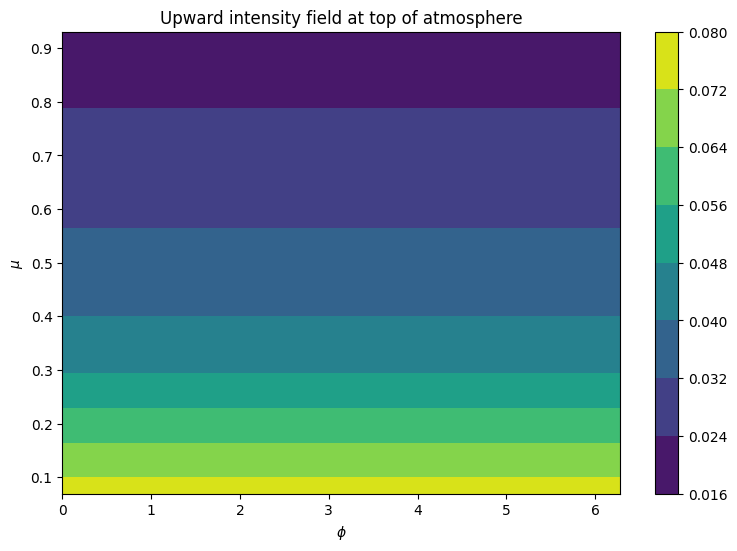

In [12]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)

----------

# 8b

**PythonicDISORT**

In [13]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = np.array([0.25, 0.5])
omega_arr = np.array([0.8, 0.95])
NQuad = 8
Leg_coeffs_all = np.zeros((2, 9))
Leg_coeffs_all[:, 0] = 1
mu0 = 0
I0 = 0
phi0 = 0

# Optional (used)
b_neg = 1 / pi

# Optional (unused)
NLeg = None
NLoops = None
b_pos = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes=[]
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [14]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_neg=b_neg,
)

**Stamnes' DISORT**

In [15]:
# tau test points
tau_test_arr = np.array([0, 0.25, 0.5])
Ntau = len(tau_test_arr)

In [16]:
# Stamnes' DISORT arguments
nlyr = 2
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = b_neg
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [17]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/8b_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [18]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 8.567015872180179e-08
Difference ratio = 4.809705844846042e-08

Downward (diffuse) fluxes
Difference = 1.0243884351890387e-07
Difference ratio = 1.57497100903911e-07

Direct (downward) fluxes
Difference = 0.0
Difference ratio = 0.0

Intensities

At tau = 0.5
Max pointwise difference = 3.871370923835826e-08
At tau = 0.5
Max pointwise difference ratio = 3.844784911901128e-07



**Does the test pass?**

In [19]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/8b_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [20]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

Text(0.5, 1.0, 'Upward intensity field at top of atmosphere')

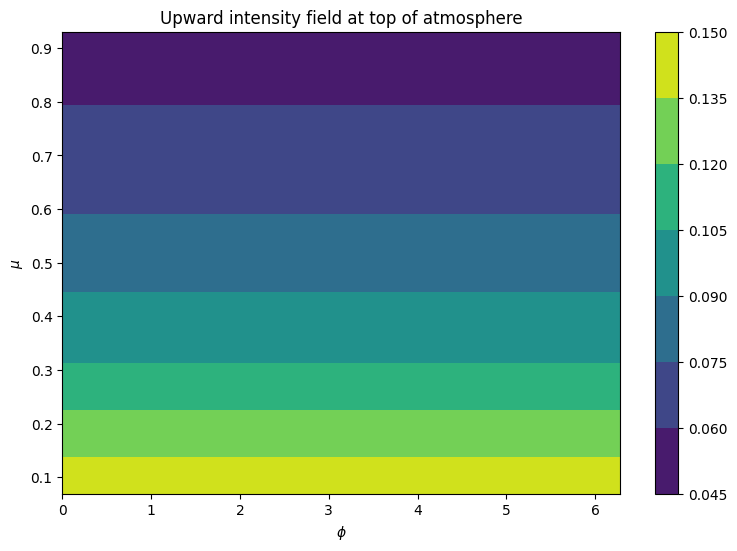

In [21]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)

-------

# 8c

**PythonicDISORT**

In [22]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = np.array([1, 3])
omega_arr = np.array([0.8, 0.95])
NQuad = 8
Leg_coeffs_all = np.zeros((2, 9))
Leg_coeffs_all[:, 0] = 1
mu0 = 0
I0 = 0
phi0 = 0

# Optional (used)
b_neg = 1 / pi

# Optional (unused)
NLeg = None
NLoops = None
b_pos = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes=[]
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [23]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_neg=b_neg,
)

**Stamnes' DISORT**

In [24]:
# tau test points
tau_test_arr = np.array([0, 0.25, 0.5])
Ntau = len(tau_test_arr)

In [25]:
# Stamnes' DISORT arguments
nlyr = 2
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = b_neg
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [26]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/8c_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [27]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 3.935641118557598e-08
Difference ratio = 1.3939494874748128e-07

Downward (diffuse) fluxes
Difference = 1.1920928966180355e-07
Difference ratio = 1.1920927545095052e-07

Direct (downward) fluxes
Difference = 0.0
Difference ratio = 0.0

Intensities

At tau = 0.5
Max pointwise difference = 2.39423134096306e-08
At tau = 0.5
Max pointwise difference ratio = 1.3725599491999314e-07



**Does the test pass?**

In [28]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/8c_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [29]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

Text(0.5, 1.0, 'Upward intensity field at top of atmosphere')

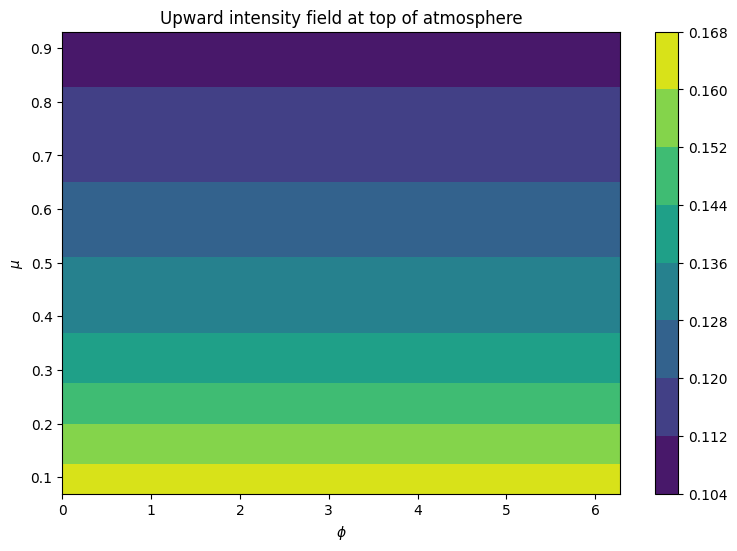

In [30]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)

-------